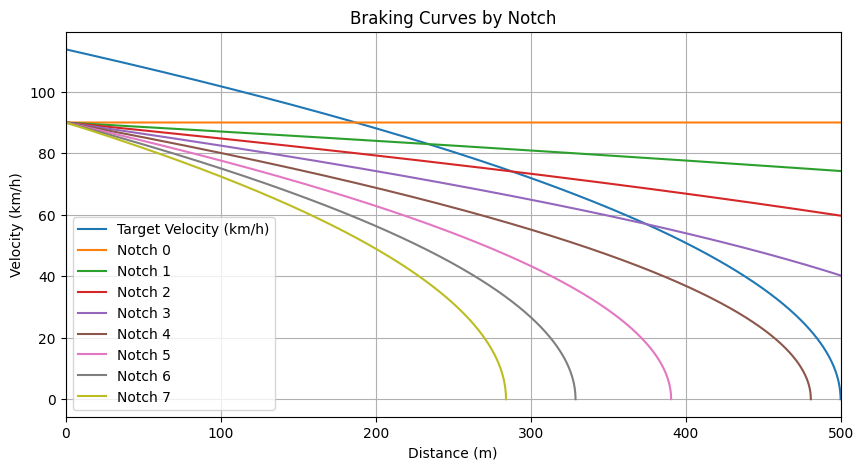

Bad pipe message: %s [b' q=0.9, image/avif, image/webp, image/apng, */*; q=0.8, application/signed-exchange; v=b3; q=0.7\r\nHost: loc', b'host:39897\r\nUser-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, lik']
Bad pipe message: %s [b'Gecko) Chrome/138.0.0.0 Safari/537.36\r\nAccept-Encoding: gzip, deflate, br, zstd\r\nAccept-Language: en']
Bad pipe message: %s [b'S, en; q=0.9, ko; q=0.8\r\nCache-Control: max-', b'e=0\r\nReferer: https://github.com/\r\nX-Request-ID: fd196a7b6eab03db2869c8371a1cb3eb\r\nX-Real-IP: 10', b'41.0.36\r\nX-Forwarded-Port: 443\r\nX-Forwarded-S']
Bad pipe message: %s [b'eme: https\r\nX-Original-URI: /\r\nX-Scheme: https\r\nDNT: 1\r\nsec-fetch-site: cross-site\r\nsec-fetch-mode']
Bad pipe message: %s [b'navigate\r\nsec-fetch-dest: document\r\nsec-ch-ua: "Not)A;Bra']
Bad pipe message: %s [b'";v="8", "Chromium";v="138", "Google Chrome";v="138"\r\nsec-ch-ua-mobile: ?0\r\nsec-ch-ua-platform: "Windows"\r\npr']


In [ ]:
import sys
sys.path.append("..")

import json
import numpy as np
import matplotlib.pyplot as plt

from simcore.models import Vehicle, Segment, SimParams
from simcore.braking_curve import build_tbc, build_notch_curves
from simcore.dynamics import run_sim
from simcore.controller import TASCController

# 1. vehicle.json 불러오기
with open("../data/vehicle.json", "r") as f:
    veh_dict = json.load(f)
veh = Vehicle(
    m = veh_dict["mass_t"] * 1000,
    a_max = veh_dict["a_max"],
    j_max = veh_dict["j_max"],
    tau_cmd = veh_dict["tau_cmd_ms"] / 1000,
    tau_brk = veh_dict["tau_brk_ms"] / 1000,
    notches = veh_dict["notches"],
    notch_accels = veh_dict["notch_accels"]
)

# 2. 시나리오 설정
seg = Segment(L=500.0, grade=0.0)
params = SimParams(dt=0.01, v0=25.0, mu=1.0)

# 3. 목표 감속 곡선 (S-curve TBC)
s_tbc, v_tbc, a_tbc = build_tbc(L=seg.L, v0=params.v0, a_max=veh.a_max, j_max=veh.j_max)

# 4. 노치별 곡선
notch_curves = build_notch_curves(L=seg.L, v0=params.v0, notch_accels=veh.notch_accels)

# 5. 컨트롤러 + 시뮬레이션
ctrl = TASCController(veh)
trace = run_sim(seg, veh, params, ctrl)

# 그래프 그리기
plt.figure(figsize=(10, 5))

# 목표 감속 곡선 (TBC)
plt.plot(s_tbc, v_tbc * 3.6, label="Target Velocity (km/h)")

# 노치별 감속 곡선
for i, (s, v) in enumerate(notch_curves):
    plt.plot(s, v * 3.6, label=f"Notch {i}")

plt.xlabel("Distance (m)")
plt.ylabel("Velocity (km/h)")
plt.title("Braking Curves by Notch")
plt.legend()
plt.grid(True)
plt.xlim(0, 500)  # 전체 거리 범위 고정

plt.show()
